<a href="https://colab.research.google.com/github/KS0999/ML/blob/main/Exercise_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
X,y = make_moons(n_samples = 1000,
                  noise = 0.1,
                  random_state = 1)

In [3]:
moons = pd.DataFrame({"X1":X[:,0],
                      "X2":X[:,1],
                      "label":y})
moons

,X1,X2,label
0,0.131942,0.340446,1
1,1.400253,-0.559485,1
2,-0.855419,0.143946,0
3,-0.693063,0.837674,0
4,0.024959,1.145901,0
...,...,...,...
995,1.226212,-0.631022,1
996,0.989685,0.452787,0
997,1.825205,0.059085,1
998,0.145087,0.875388,0


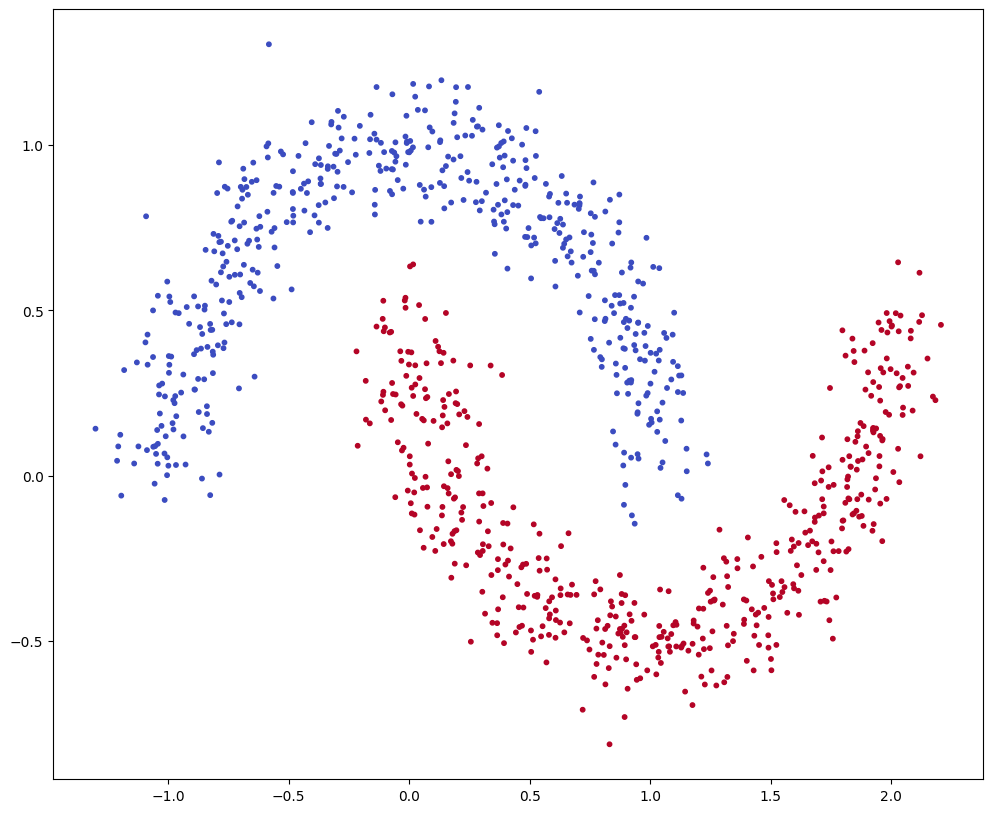

In [4]:
plt.figure(figsize=(12,10))
plt.scatter(X[:,0],X[:,1],c=y,cmap="coolwarm",s=10)

In [5]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 train_size = 0.8,
                                                 test_size = 0.2,
                                                 random_state = 1)

In [7]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [8]:
class moonmodel(nn.Module):
  def __init__(self,in_feature = 2,out_features = 1,hidden_layer=8):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(in_feature,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer,out_features)
    )
  def forward(self,x):
    return self.layer(x)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
model = moonmodel().to(device)
model.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[ 0.2503, -0.0490],
                      [-0.3750,  0.2115],
                      [-0.4315,  0.3069],
                      [ 0.1227, -0.6983],
                      [ 0.3024, -0.5767],
                      [ 0.2006, -0.3319],
                      [-0.6485,  0.4453],
                      [-0.6373,  0.6598]], device='cuda:0')),
             ('layer.0.bias',
              tensor([ 0.6893, -0.3127,  0.1979,  0.6153, -0.6653, -0.1642, -0.0607, -0.0293],
                     device='cuda:0')),
             ('layer.2.weight',
              tensor([[-0.1977,  0.0815, -0.1442, -0.0977, -0.0983, -0.0140, -0.2665,  0.2694],
                      [-0.1200, -0.1057,  0.1038, -0.3134,  0.1553,  0.0846,  0.1663, -0.2222],
                      [ 0.2825, -0.3452,  0.0549,  0.2946, -0.0313, -0.3000, -0.2079, -0.3255],
                      [ 0.2474, -0.1467, -0.1713, -0.3490,  0.0589,  0.1415,  0.2925, -0.2471],
                      [ 0.3085,

In [11]:
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(lr=0.1,
                            params = model.parameters())

In [12]:
X_test,X_train = X_test.to(device),X_train.to(device)
y_test,y_train = y_test.to(device),y_train.to(device)

In [13]:
model.eval()
with torch.inference_mode():
  y_logit = model(X_test).squeeze()

In [14]:
y_pred_pros = torch.sigmoid(y_logit)[:5]

In [15]:
y_pred_label = torch.round(y_pred_pros)
y_pred_label[:5]

tensor([0., 1., 0., 1., 1.], device='cuda:0')

In [16]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct / len(y_pred))*100
  return acc

In [17]:
epochs = 1000

for epoch in range(epochs):
  model.train()
  # do the forward pass
  y_logit = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))
  # calculate the loss & acc
  loss = loss_fn(y_logit,y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  # optimizer the zero grad
  optimizer.zero_grad()
  # loss backward
  loss.backward()
  # optimizer step
  optimizer.step()

  model.eval()
  # do the forward pass
  with torch.inference_mode():
    test_logit = model(X_test).squeeze()
    test_label = torch.round(torch.sigmoid(test_logit))
  # calculate the loss & acc
  test_loss = loss_fn(test_logit,y_test)
  test_acc = accuracy_fn(y_true = y_test,
                         y_pred = test_label)
  if (epoch%50==0):
    print(f" Epoch {epoch},Loss:{loss:.5f} ,acc:{acc}% ,test_loss:{test_loss:.5f},test_acc:{test_acc}%")

 Epoch 0,Loss:0.72712 ,acc:16.25% ,test_loss:0.72612,test_acc:17.0%
 Epoch 50,Loss:0.65202 ,acc:77.5% ,test_loss:0.64397,test_acc:81.0%
 Epoch 100,Loss:0.47644 ,acc:82.25% ,test_loss:0.44317,test_acc:88.5%
 Epoch 150,Loss:0.32857 ,acc:83.375% ,test_loss:0.28287,test_acc:87.5%
 Epoch 200,Loss:0.28163 ,acc:86.25% ,test_loss:0.23664,test_acc:89.5%
 Epoch 250,Loss:0.26045 ,acc:88.25% ,test_loss:0.21733,test_acc:91.0%
 Epoch 300,Loss:0.24565 ,acc:89.375% ,test_loss:0.20520,test_acc:91.0%
 Epoch 350,Loss:0.23379 ,acc:90.125% ,test_loss:0.19697,test_acc:91.0%
 Epoch 400,Loss:0.22364 ,acc:90.5% ,test_loss:0.18937,test_acc:92.5%
 Epoch 450,Loss:0.21269 ,acc:90.875% ,test_loss:0.18108,test_acc:92.5%
 Epoch 500,Loss:0.19982 ,acc:91.25% ,test_loss:0.17138,test_acc:93.0%
 Epoch 550,Loss:0.18466 ,acc:92.375% ,test_loss:0.15975,test_acc:93.5%
 Epoch 600,Loss:0.16684 ,acc:93.5% ,test_loss:0.14604,test_acc:95.0%
 Epoch 650,Loss:0.14669 ,acc:94.5% ,test_loss:0.13069,test_acc:96.0%
 Epoch 700,Loss:0.1234

In [18]:
import os
import pathlib as path
import requests

In [19]:
if os.path.isfile("helper_functions.py"):
  print(" helper_functions.py is exist ...")
else:
  print(" helper_functions.py isn't exist ! Preparing for download ...")
  url = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as file:
    file.write(url.content)

 helper_functions.py isn't exist ! Preparing for download ...


In [21]:
import helper_functions
from helper_functions import plot_decision_boundary

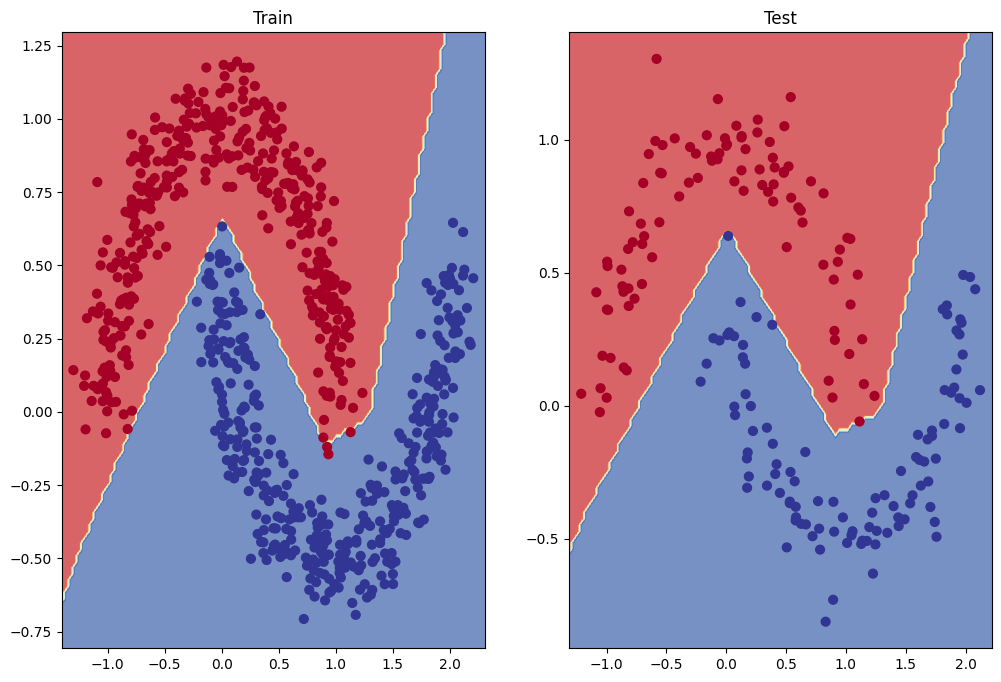

In [26]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,X_test,y_test)